# **Import and Download module**

In [ ]:
!wget https://github.com/Natthapolmnc/BertSentimentAnalysis/raw/main/data_set/reviews_Musical_Instruments_5.json.gz

--2021-03-15 11:22:01--  https://github.com/Natthapolmnc/BertSentimentAnalysis/raw/main/data_set/reviews_Musical_Instruments_5.json.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Natthapolmnc/BertSentimentAnalysis/main/data_set/reviews_Musical_Instruments_5.json.gz [following]
--2021-03-15 11:22:01--  https://raw.githubusercontent.com/Natthapolmnc/BertSentimentAnalysis/main/data_set/reviews_Musical_Instruments_5.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2460495 (2.3M) [application/octet-stream]
Saving to: ‘reviews_Musical_Instruments_5.json.gz’

reviews_Musical_Ins 100%[=======

In [ ]:
!pip install tokenizers

     |████████████████████████████████| 3.2MB 18.8MB/s 


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 17.5MB/s 
     |████████████████████████████████| 890kB 41.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=90e6e02d9df13969152fbaa6478b7de120ef52f5a085006086331fd3ae8c0cb7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import os
import pickle as pkl
import numpy as np
import gzip
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

In [ ]:
configuration = BertConfig(num_hidden_layers=2,num_attention_heads=4)

In [ ]:
encoder = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# **Bert data-prep**

In [ ]:
np.random.seed(42)

In [ ]:
def StratifiedSplit(dat,label_name,split_ratio):
  total_row=dat.count()[0]
  labels=dat[label_name].unique()
  ratio_dict={}
  for i in labels:
    ratio_dict[i]=dat.where(dat[label_name]==i).dropna().count()[0]/total_row
  num_sample=int(total_row*split_ratio)
  test_df=pd.DataFrame(columns=dat.columns)
  train_df=pd.DataFrame(columns=dat.columns)
  for i in labels:
    num_sample_label =int(num_sample*ratio_dict[i])
    dat_sm=dat.where(dat[label_name]==i).dropna()
    dat_sm=dat_sm.sample(frac=1)
    msk = np.random.rand(dat_sm.count()[0]) < (num_sample_label/dat_sm.count()[0])
    test_df=test_df.append(dat_sm[msk])
    train_df=train_df.append(dat_sm[~msk])
  return (train_df, test_df)

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/reviews_Musical_Instruments_5.json.gz')
df = df[['reviewText','overall']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10261 entries, 0 to 10260
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  10261 non-null  object 
 1   overall     10261 non-null  float64
dtypes: float64(1), object(1)
memory usage: 240.5+ KB


In [ ]:
max_seq=500
min_seq=50

In [ ]:
def splitSentiment(x):
  if x<3:
    return 0
  elif x==3:
    return 1
  elif x>3:
    return 2

In [ ]:
df=df[(df['reviewText'].apply(lambda x: x.split()).apply(lambda x:len(x))<max_seq) & (df['reviewText'].apply(lambda x: x.split()).apply(lambda x:len(x))>min_seq)]

In [ ]:
good = df[df['overall']>=4]
neutral = df[df['overall']==3]
bad = df[df['overall']<=2]
_min = min(good.shape[0],neutral.shape[0],bad.shape[0])
good = good.sample(n=_min)
neutral = neutral.sample(n=_min)
bad = bad.sample(n=_min)
df = pd.concat([good,neutral,bad])
df = df.sample(frac=1)

In [ ]:
df["overall"]=df["overall"].apply(splitSentiment)

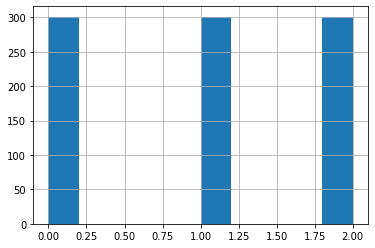

In [ ]:
df["overall"].hist()

In [ ]:
train_, test_=StratifiedSplit(df,"overall",0.2)

In [ ]:
### LOAD BERT TOKENIZERS ###
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

In [ ]:
train_

,reviewText,overall
3425,I was hoping the Lemon oil would be what I nee...,1.0
4818,Behringer makes quality products - I purchased...,1.0
2039,I used this on the side of a wooden bookshelf ...,1.0
8283,I've owned four of these over the past two yea...,1.0
5709,I was looking for an Overdrive or Distortion p...,1.0
...,...,...
7206,So i decided to amplify my Martin Dreadnaught ...,2.0
9422,The product is here and I am glad the size is ...,2.0
5423,Im using this with five pedals and it works gr...,2.0
1107,I bought this mic after hearing good things ab...,2.0


In [ ]:
x_ids_tr=[tokenizer.encode(i).ids for i in train_["reviewText"]]
x_ids_tr=pad_sequences(x_ids_tr,maxlen=max_seq,padding="post")
x_msk_tr=[tokenizer.encode(i).attention_mask for i in train_["reviewText"]]
x_msk_tr=pad_sequences(x_msk_tr,maxlen=max_seq,padding="post")
y_tr=to_categorical(train_["overall"].values)

In [ ]:
train_["overall"]

3425    1.0
4818    1.0
2039    1.0
8283    1.0
5709    1.0
       ... 
7206    2.0
9422    2.0
5423    2.0
1107    2.0
7942    2.0
Name: overall, Length: 732, dtype: float64

In [ ]:
x_ids_t=[tokenizer.encode(i).ids for i in test_["reviewText"]]
x_ids_t=pad_sequences(x_ids_t,maxlen=max_seq,padding="post")
x_msk_t=[tokenizer.encode(i).attention_mask for i in test_["reviewText"]]
x_msk_t=pad_sequences(x_msk_t,maxlen=max_seq,padding="post")
y_t=to_categorical(test_["overall"].values)

# **BERT Model**

In [ ]:
#Bert
input_ids = tf.keras.layers.Input(shape=(max_seq,), dtype=tf.int32)
attn_mask = tf.keras.layers.Input(shape=(max_seq,), dtype=tf.int32)
## CLS=1 All word emb=0
wrd_embedding = encoder(input_ids, attention_mask=attn_mask)[0]

### Attention
drop=tf.keras.layers.Dropout(0.8)(wrd_embedding)
res=tf.keras.layers.Dense(8,activation="softmax")(drop)

### Result Dense
res=tf.keras.layers.Dense(4,activation="softmax")(drop)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f9c9a2eb2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f9c9a2eb2a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf


KeyboardInterrupt



In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=3,
        verbose=1,
    )
]

In [ ]:
model=tf.keras.Model(inputs=[input_ids,attn_mask] ,outputs=res)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 500, 16)      12304       tf_bert_model[6][0]        

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

In [ ]:
history=model.fit(x=[x_ids_tr,x_msk_tr],y=y_tr,epochs=10,validation_data=([x_ids_t,x_msk_t],y_t),verbose=1,batch_size=64,callbacks=callbacks)

Epoch 1/20
12/12 [==============================] - 49s 4s/step - loss: 3.5799 - accuracy: 0.3762 - val_loss: 1.1898 - val_accuracy: 0.3509
Epoch 2/20
12/12 [==============================] - 41s 3s/step - loss: 1.1710 - accuracy: 0.3458 - val_loss: 1.1084 - val_accuracy: 0.3743
Epoch 3/20
12/12 [==============================] - 42s 4s/step - loss: 1.1092 - accuracy: 0.3488 - val_loss: 1.1028 - val_accuracy: 0.3743
Epoch 4/20
12/12 [==============================] - 42s 4s/step - loss: 1.1044 - accuracy: 0.3349 - val_loss: 1.1016 - val_accuracy: 0.3743
Epoch 5/20
12/12 [==============================] - 42s 4s/step - loss: 1.1030 - accuracy: 0.3622 - val_loss: 1.1011 - val_accuracy: 0.4386
Epoch 6/20
12/12 [==============================] - 42s 4s/step - loss: 1.1005 - accuracy: 0.3983 - val_loss: 1.1008 - val_accuracy: 0.4386
Epoch 7/20
12/12 [==============================] - 42s 4s/step - loss: 1.1010 - accuracy: 0.3811 - val_loss: 1.1005 - val_accuracy: 0.4152
Epoch 8/20
12/12 [==